# Create images

A base image plus the pokemon!  The base image is randonmly selected from the trtain dataset in the classic https://www.kaggle.com/c/dogs-vs-cats/

In order to create a labeled dataset we select 5000 random images from the cat vs dog dataset and put over it the selected pokemon... each image have a different size and a different rotation so we can get enough variance to train a generalizable model.

At the beginin i tried to run this model for all the pokemons but i had to use a lot of images and i was not getting good results (Accuracy). For the model what i implemented is just an MVP classifier that only recognice the starter pokemons (+Pikachu) plus my fav ones! (Yes my fav game was pokemon Ruby/Emerald)

- Charmander
- Squirtle
- Bulbasaur
- Pikachu
- Machop
- Gengar
- Mew
- Mewtwo
- Cyndaquil
- Totodile
- Chikorita
- Mudkip
- Torchic
- Treeko
- Mightyena
- Metagross
- Milotic
- Salamance 
- Kyogre
- Groudon
- Latios
- Rayquaza



In [1]:

from PIL import Image, ImageDraw, ImageFilter
import requests
import random
import pandas as pd
import os 
from glob import glob

data = pd.read_csv('..\\data\\all_stats.csv')
n_images = 5000

poke_ids = [1,4,7,25,66,94,150,151,152,155,158,
            373,376,350,381,382,383,384,252,262,
           255,252,258]

#for poke_id in range(1,data.pos.max()+1):
for poke_id in poke_ids:
    bases = glob('base/*')
    random.shuffle(bases)
    poke_name = data[data.pos==poke_id].name.iloc[0]
    url = data[data.pos==poke_id].im1.iloc[0]
    poke_image = Image.open(requests.get(url, stream=True).raw)
    base_path = 'images\\' + poke_name
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    for i in range(n_images):
        im1 = Image.open(bases[i]).resize((256,256))
        size = random.randint(64,64*3)
        theta = random.randint(-120,120)
        im2 = poke_image.resize((size,size)).rotate(theta)
        x0 = random.randint(1,256-size)
        y0 = random.randint(1,256-size)
        im1.paste(im2,(x0, y0))
        name = base_path + '\\'+ str(i) + '.jpg'
        im1.save(name)



# Set transfer learning



In [2]:
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import shutil, os

## Create folders for train and test with labels

In [3]:
if not os.path.exists('images/train'):
    os.makedirs('images/train')
if not os.path.exists('images/test'):
    os.makedirs('images/test')
pose_names = [ a.split('\\')[1] for a in glob('images/*')]

for key in pose_names:
    if (key!='train') & (key!='test'):
        path =  'images/train/'+ key
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            for f in glob(path+'/*'):
                os.remove(f)
        path =  'images/test/'+ key
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            for f in glob(path+'/*'):
                os.remove(f)
            

# Split train and test

In [4]:
for i in glob('images/*'):
    files= glob(i+'/*.jpg')
    if (len(files)>0):
        random.shuffle(files)
        ntrain = int(len(files)*0.8)
        train = files[:ntrain] 
        test = files[ntrain:]
        pose=i.split('\\')[1]
        for f in train:
            shutil.copy(f, 'images/train/'+pose)
        for f in test:
            shutil.copy(f, 'images/test/'+pose)

        

In [5]:

# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.2)(x)
CLASSES = len(glob('images/train/*'))
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

WIDTH = 2**8
HEIGHT = 2**8

BATCH_SIZE = 2**8
EPOCHS = 6


# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')



STEPS_PER_EPOCH = int(train_generator.samples/train_generator.batch_size)
VALIDATION_STEPS = int(validation_generator.samples/validation_generator.batch_size)

MODEL_FILE = 'my_inception_tf.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Found 97600 images belonging to 28 classes.
Found 24400 images belonging to 28 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 381 steps, validate for 95 steps
Epoch 1/6
381/381 [==============================] - 1826s 5s/step - loss: 1.9434 - accuracy: 0.5124 - val_loss: 2.8992 - val_accuracy: 0.2829
Epoch 2/6
381/381 [==============================] - 1311s 3s/step - loss: 1.3439 - accuracy: 0.6472 - val_loss: 3.1791 - val_accuracy: 0.3011
Epoch 3/6
381/381 [==============================] - 1313s 3s/step - loss: 1.2128 - accuracy: 0.6763 - val_loss: 3.0546 - val_accuracy: 0.3297
Epoch 4/6
381/381 [==============================] - 1309s 3s/step - loss: 1.1592 - accuracy: 0.6882 - val_loss: 3.5081 - val_accuracy: 0.2972
Epoch 5/6
381/381 [==============================] - 1316s 3s/step - loss: 1.1283 - accuracy: 0.6949 - val_loss: 3.2888 - val_accuracy: 0.3373
Epoch 6/6
381/381 [=========

## Check whats going on

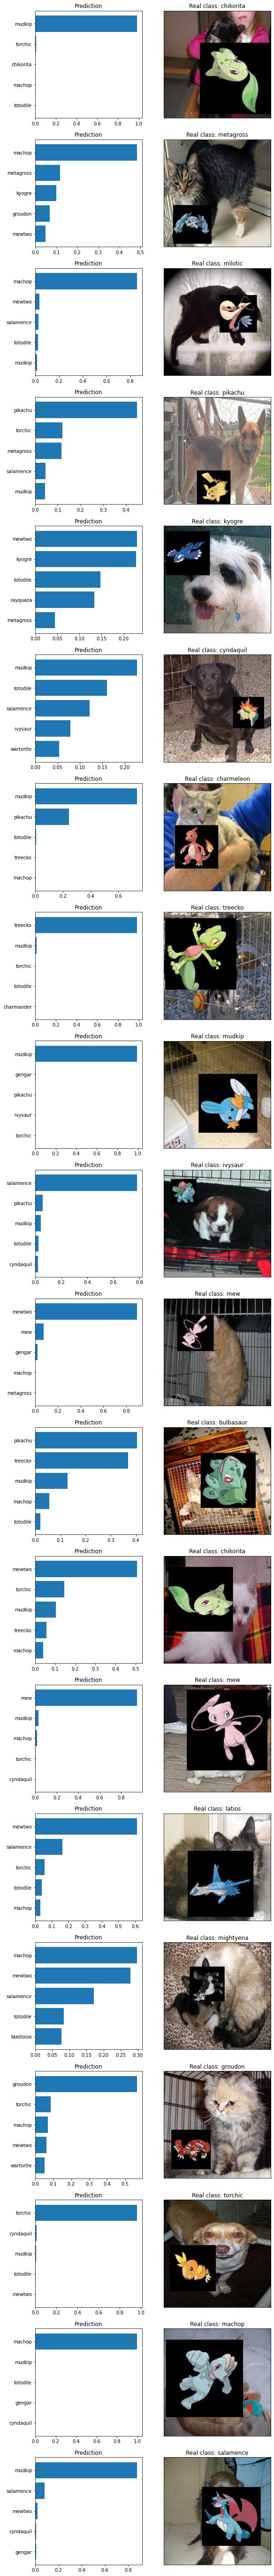

In [6]:
k=20
labs =  [ s.split('/', 1)[0] for s in validation_generator.filenames ]
random.shuffle(labs)
test_images=labs[:k]

labels =[ re.sub('images/train', '', s).split('\\')[1] for s in glob('images/train/*')]
plt.rcParams['figure.figsize'] = [9,5*k]
fig, axs = plt.subplots(nrows=k, ncols=2)
f=0
for im in test_images:
    img = image.load_img('images\\test\\'+im, target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y = model.predict(x)
    data=pd.DataFrame({'label':labels,'prob':y[0]}).sort_values(
          by=['prob']).tail()
    c=0
    axs[f,c].barh(data.label, data.prob, align='center')
    axs[f,c].set_title('Prediction')

    c=1
    axs[f,c].imshow(np.asarray(img))
    axs[f,c].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    axs[f,c].set_title('Real class: '+im.split('\\')[0])
    f=f+1

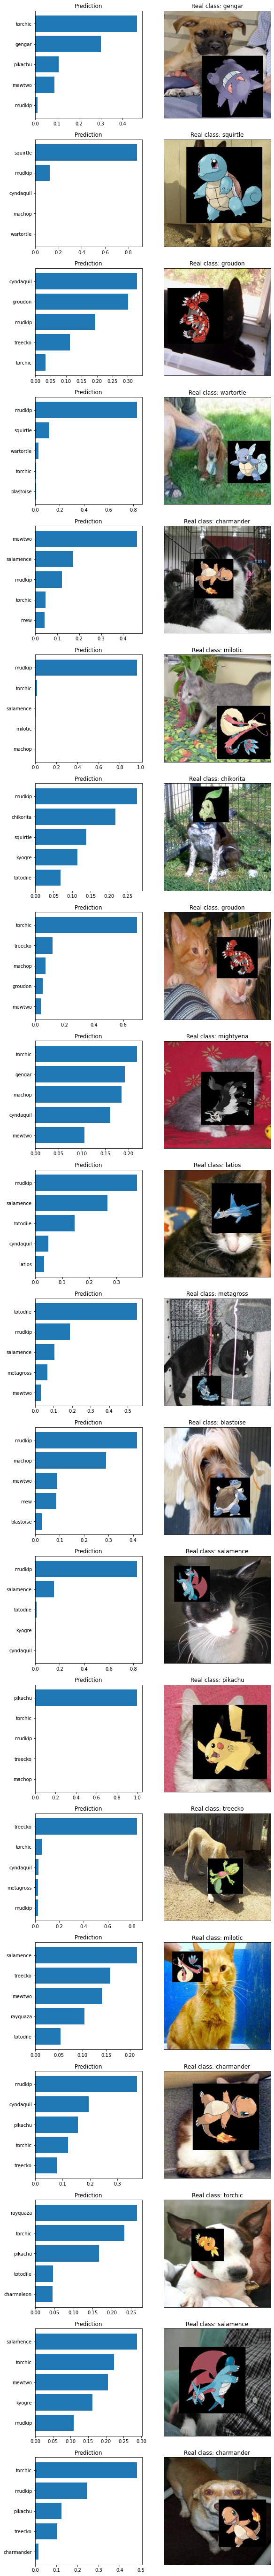

In [7]:
k=20
labs =  [ s.split('/', 1)[0] for s in train_generator.filenames ]
random.shuffle(labs)
test_images=labs[:k]

labels =[ re.sub('images/train', '', s).split('\\')[1] for s in glob('images/train/*')]
plt.rcParams['figure.figsize'] = [9,5*k]
fig, axs = plt.subplots(nrows=k, ncols=2)
f=0
for im in test_images:
    img = image.load_img('images\\train\\'+im, target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y = model.predict(x)
    data=pd.DataFrame({'label':labels,'prob':y[0]}).sort_values(
          by=['prob']).tail()
    c=0
    axs[f,c].barh(data.label, data.prob, align='center')
    axs[f,c].set_title('Prediction')

    c=1
    axs[f,c].imshow(np.asarray(img))
    axs[f,c].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    axs[f,c].set_title('Real class: '+im.split('\\')[0])
    f=f+1

# Create the prediction function

The app is build using R so we have to run a model in conda envioronment by just calling the a single python function.  The only parameter should be a str with an image file and the function should return the a dataframe of the top 5 predictions.


In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

model = load_model('my_inception_tf.model')
WIDTH = 2**8
HEIGHT = 2**8

labels = ['blastoise','bulbasaur','charizard','charmander','charmeleon','chikorita','cyndaquil',
     'gengar','groudon','ivysaur','kyogre','latios','machop','metagross','mew','mewtwo','mightyena',
     'milotic','mudkip','pikachu','rayquaza','salamence','squirtle','torchic','totodile','treecko',
     'venusaur','wartortle']
def poke_prediction(file):    
    img = image.load_img(file, target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y = model.predict(x)
    result = pd.DataFrame({'label':labels,'prob':y[0]}).sort_values(
              by=['prob']).tail()
    return result

In [15]:

    
poke_prediction('images/groudon/1.jpg')

label      prob
18     mudkip  0.002435
23    torchic  0.004307
6   cyndaquil  0.008173
12     machop  0.009869
8     groudon  0.972541

In [16]:
poke_prediction('images/milotic/1.jpg')

label      prob
25    treecko  0.007311
15     mewtwo  0.037383
17    milotic  0.087954
21  salamence  0.191578
18     mudkip  0.649848

In [23]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

RuntimeError: Virtual devices cannot be modified after being initialized